In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pickle

## 4. Modeling

### 4.1. Prepare the training set and testing set

In [2]:
listing34 = pd.read_csv("temp/listing34.csv")
X = listing34.drop(columns=[col for col in listing34 if ('price' in col) 
                            or ('zipcode' in col) 
                            or ('availability' in col)
                           ])
y = listing34['price']

# Shuffle and split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 5364 samples.
Testing set has 1341 samples.


### 4.2. Initial evaluation of linear and tree-based models

To evaluate model performance, I chose MSE (mean squared error). The square root of MSE will then represents the dollar amount by which our prediction is off.

In [3]:
# Linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(f"Training error: {rmse_train}")
print(f"Testing error: {rmse_test}")

Training error: 85.56470834004769
Testing error: 43708749853.20042


In [4]:
# Ridge
reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(f"Training error: {rmse_train}")
print(f"Testing error: {rmse_test}")

Training error: 85.82647345516976
Testing error: 96.143249390053


In [5]:
# Lasso
reg = Lasso()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(f"Training error: {rmse_train}")
print(f"Testing error: {rmse_test}")

Training error: 94.37160636791414
Testing error: 99.52596447306513


In [6]:
# ElasticNet
reg = ElasticNet()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(f"Training error: {rmse_train}")
print(f"Testing error: {rmse_test}")

Training error: 110.56668994890765
Testing error: 115.11823803724161


In [7]:
# RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(f"Training error: {rmse_train}")
print(f"Testing error: {rmse_test}")

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training error: 35.31318555193659
Testing error: 81.51468522623205


With the default hyperparameters of each model, Random Forest model has much lower error in both training and testing sets, suggesting that price prediction is a non-linear problem. Therefore, Random Forest was chosen for further tuning. To play with a linear model, Ridge was also chosen for further tuning.

### 4.3. Tuning Ridge and Random Forest models

#### Ridge

In [8]:
# Initialize the regressor
reg = Ridge(random_state=42)

# Create the parameters to tune
parameters = {'alpha': [0.1, 1, 10, 100], 
              'normalize': [True, False], 
              'max_iter': [1000, 2000, 5000],
              'solver': ['auto'],
             }

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(reg, parameters, scoring='neg_mean_squared_error', n_jobs=2, cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_reg = grid_fit.best_estimator_

# Save the best model to disk
filename = 'temp/model_ridge.pkl'
pickle.dump(best_reg, open(filename, 'wb'))

# Make predictions using the optimized model
y_train_pred = best_reg.predict(X_train)
y_test_pred = best_reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(best_reg)
print(f"\nTraining error: {rmse_train}")
print(f"Testing error: {rmse_test}")

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=42, solver='auto', tol=0.001)

Training error: 86.98847542644087
Testing error: 95.7457796377797


#### Random Forest

In [9]:
# Initialize the regressor
reg = RandomForestRegressor(random_state=42)

# Create the parameters to tune
parameters = {'n_estimators': [10, 100, 500],
              'max_depth': [5, 20, 40, 60],
              'min_samples_leaf': [5, 10, 50],
              'max_features': ['sqrt', 'auto', 0.5, 1],
             }

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(reg, parameters, scoring='neg_mean_squared_error', n_jobs=2, cv=3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_reg = grid_fit.best_estimator_

# Save the best model to disk
filename = 'temp/model_rf.pkl'
pickle.dump(best_reg, open(filename, 'wb'))

# Make predictions using the optimized model
y_train_pred = best_reg.predict(X_train)
y_test_pred = best_reg.predict(X_test)
rmse_train = mean_squared_error(y_train, y_train_pred) ** (0.5)
rmse_test = mean_squared_error(y_test, y_test_pred) ** (0.5)
print(best_reg)
print(f"\nTraining error: {rmse_train}")
print(f"Testing error: {rmse_test}")

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Training error: 54.72875578377298
Testing error: 80.11047087606444


The objective here is not to build an accurate model to predict price, but to figure out what the most importance features are. Random Forest in sklearn is able to extract feature importance, but the positive vs negative influence of the feature on price is unknown. Ridge is a linear model so that the fitted coefficient directly reflects the direction, and by how much, price is influenced by the feature. Therefore, I will stop tuning and use the current Random Forest model to evaluate feature importance.

### 4.4. Feature importance

In [10]:
# Load the best model from disk
filename = 'temp/model_ridge.pkl'
best_reg = pickle.load(open(filename, 'rb'))

# Extract the feature importances based on the optimized model
# importances = best_reg.feature_importances_
importances = best_reg.coef_
feature_importance = pd.DataFrame({"variable": X_train.columns.tolist(), "importance": importances})
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False).reset_index(drop=True)
# feature_importance.head()

#### Most important features in predicting price

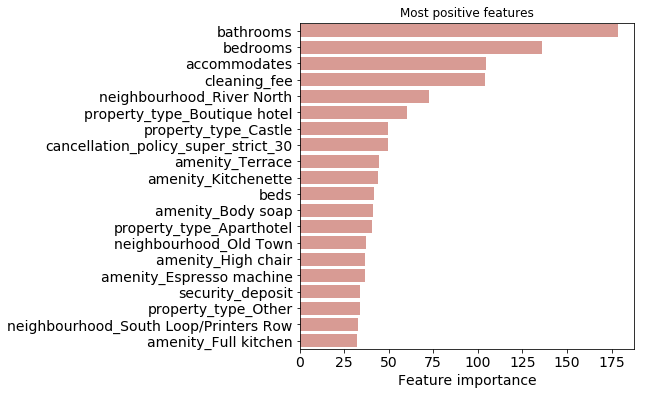

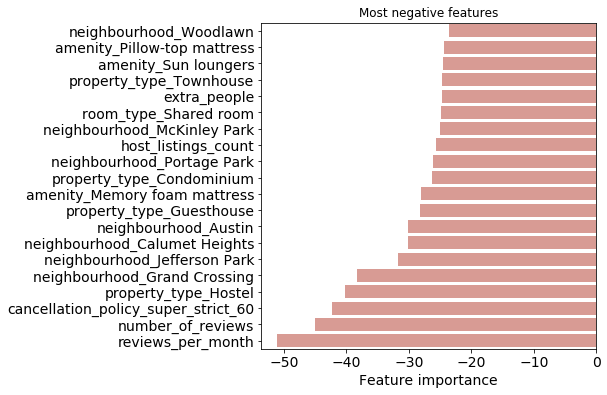

In [11]:
# Visualize feature importance
plt.figure(figsize=(6,6))
sns.barplot(x="importance", y="variable", data=feature_importance.iloc[:20, :],
               color="salmon", saturation=.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Feature importance', fontsize=14)
plt.title('Most positive features')
plt.savefig(f'figures/feature_importance1.png', bbox_inches="tight", dpi = 300)

plt.figure(figsize=(6,6))
sns.barplot(x="importance", y="variable", data=feature_importance.iloc[-20:, :],
               color="salmon", saturation=.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Feature importance', fontsize=14)
plt.title('Most negative features')
plt.savefig(f'figures/feature_importance2.png', bbox_inches="tight", dpi = 300)

#### Check the importance of different kinds of features individually

In [12]:
# Amenities
print('Amenities:')
am_importance = feature_importance.loc[feature_importance['variable'].str.contains('amenit')]
pd.concat([am_importance[:10], am_importance[-10:]])

Amenities:


,variable,importance
8,amenity_Terrace,44.630853
9,amenity_Kitchenette,43.921281
11,amenity_Body soap,41.215463
14,amenity_High chair,36.814729
15,amenity_Espresso machine,36.456499
19,amenity_Full kitchen,32.261321
20,amenity_En suite bathroom,31.700409
21,amenity_Suitable for events,31.465834
23,amenity_Roll-in shower,30.383492
24,amenity_Exercise equipment,30.260600


In [13]:
# Plot feature importance
def plot_importance(feature_importance, col_name, strip = True):
    importance = feature_importance.loc[feature_importance['variable'].str.contains(col_name)]
    if strip:
        importance[col_name] = importance['variable'].apply(lambda x: x[len(col_name)+1:])
    else:
        importance[col_name] = importance['variable']

    # Visualize feature importance
    print(f"{col_name}:")
    plt.figure(figsize=(6,20/60*importance.shape[0]))
    sns.barplot(x="importance", y=col_name, data=importance,
                   color="salmon", saturation=.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('')
    plt.xlabel('Feature importance', fontsize=14);

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


neighbourhood:


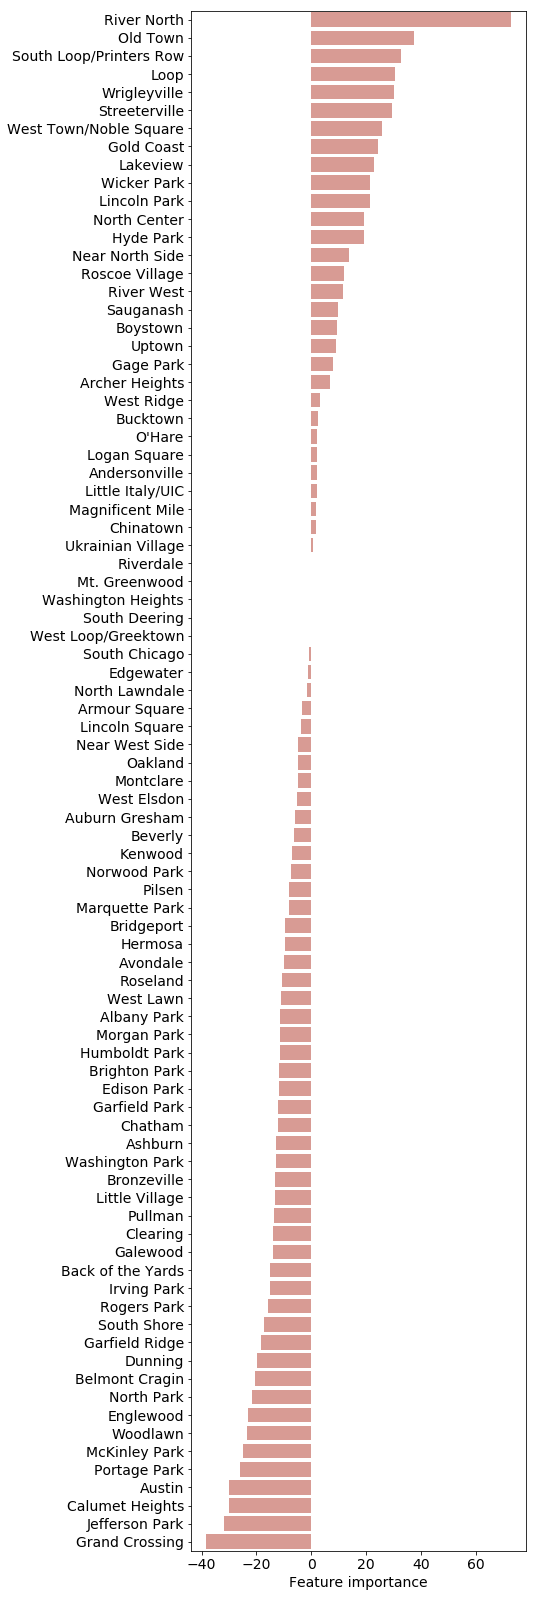

In [14]:
# neighbourhood
plot_importance(feature_importance, 'neighbourhood')
# feature_importance.loc[feature_importance['variable'].str.contains('neighb')]

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


property_type:


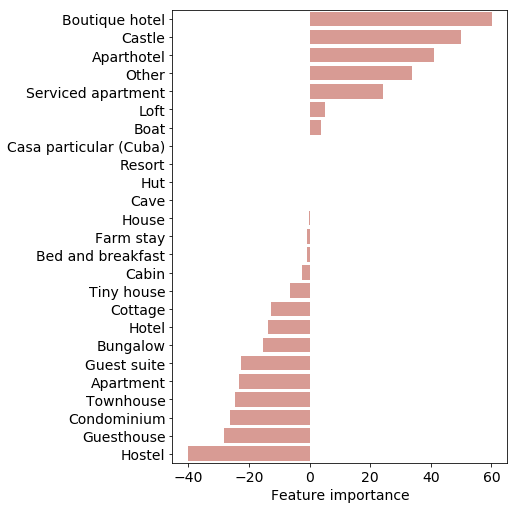

In [15]:
# property_type
plot_importance(feature_importance, col_name = 'property_type')
# feature_importance.loc[feature_importance['variable'].str.contains('property_type')]

bed_type:


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


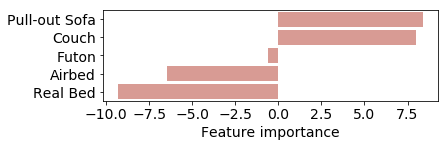

In [16]:
# bed_type
plot_importance(feature_importance, col_name = 'bed_type')
# feature_importance.loc[feature_importance['variable'].str.contains('bed_type')]

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


room_type:


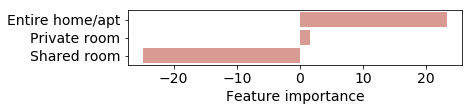

In [17]:
# room_type
plot_importance(feature_importance, col_name = 'room_type')
# feature_importance.loc[feature_importance['variable'].str.contains('room_type')]

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


review:


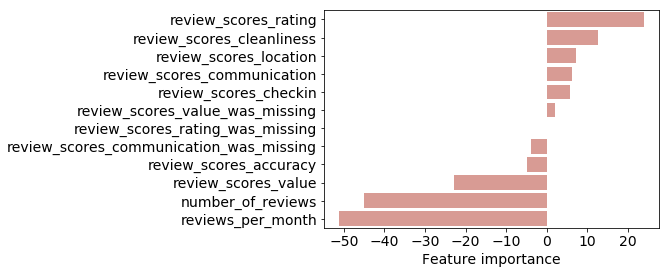

In [18]:
# review
plot_importance(feature_importance, col_name = 'review', strip=False)
# feature_importance.loc[feature_importance['variable'].str.contains('review')]

sentiment:


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


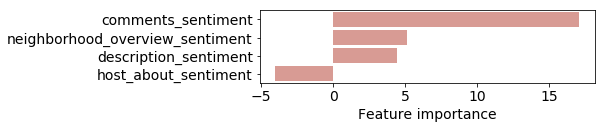

In [19]:
# sentiment
plot_importance(feature_importance, col_name = 'sentiment', strip=False)
# feature_importance.loc[feature_importance['variable'].str.contains('sentiment')]

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count:


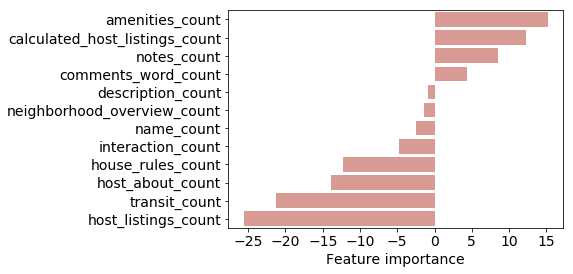

In [20]:
# count
plot_importance(feature_importance, col_name = 'count', strip=False)
# feature_importance.loc[feature_importance['variable'].str.contains('count')]

pic:


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


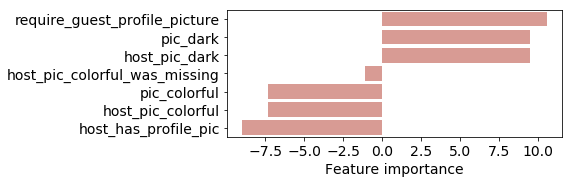

In [21]:
# pic
plot_importance(feature_importance, col_name = 'pic', strip=False)
# feature_importance.loc[feature_importance['variable'].str.contains('pic')]

In [22]:
# remaining variables
feature_names = feature_importance['variable'].tolist()
remaining = [col for col in feature_names if
 ('ameni' not in col) and
 ('neighb' not in col) and
 ('type' not in col) and 
 ('review' not in col) and
 ('sentiment' not in col) and
 ('count' not in col) and
 ('pic' not in col)
]
feature_importance.loc[feature_importance['variable'].isin(remaining)]

,variable,importance
0,bathrooms,178.844467
1,bedrooms,136.140359
2,accommodates,104.833290
3,cleaning_fee,104.153330
7,cancellation_policy_super_strict_30,49.387674
10,beds,41.717248
16,security_deposit,33.934951
72,host_identity_verified,11.010794
90,guests_included,8.438379
100,cancellation_policy_strict_14_with_grace_period,6.863972
